# Type I Migration with an Inner Disk Edge

Rather than prescribing migration, eccentricity and inclination damping timescales directly, we use a model for Type I Migration that calculates those timescales from physical disk parameters.

We initialize a single planet at a semimajor axis of 1 AU

In [1]:
import rebound
import reboundx
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sim = rebound.Simulation()
sim.units = ('yr', 'AU', 'Msun')
sim.add(m = 1)
a0=1
sim.add(m = 1.e-4, a=a0, e=0, inc = 0)
sim.move_to_com()
ps = sim.particles

Now we add the `type_I_migration` effect, and set the appropriate disk parameters. Note that we chose code units of AU for all the distances above. We require

* The disk scale height in code units (here AU), 1 code unit from the central star ($h_1$) 
* The disk surface density 1 code unit from the central star ($\Sigma_1$) 
* The disk surface density exponent ($\alpha$), assuming a power law $\Sigma(r) = \Sigma_1 r^{-\alpha}$, where $r$ is the radial distance from the star in code units
* The disk flaring index ($\beta$), assuming a power-law scale height $h(r) = h_1 r^\beta$

In [3]:
rebx = reboundx.Extras(sim)
mig = rebx.load_force("type_I_migration")
rebx.add_force(mig)

mig.params["tIm_scale_height_1"] = 0.03
mig.params["tIm_surface_density_1"] = 1.1e-4 # 1000 g/cm^2 surface density in Msun/AU^2
mig.params["tIm_surface_density_exponent"] = 1
mig.params["tIm_flaring_index"] = 0.25

We can also add an inner disk edge (ide) to halt migration. This is an artificial prescription for halting the planet at `ide_position` (in code units, here AU). 

We also have to set the 'width' of the inner disk edge in code units. This is the width of the region in which the migration torque flips sign, so the planet will stop within this distance scale of the inner disk edge's location. 

Here we set the width to the scale height of the disk at the inner disk edge:

In [4]:
mig.params["ide_position"] = 0.1
mig.params["ide_width"] = mig.params["tIm_scale_height_1"]*mig.params["ide_position"]**mig.params["tIm_flaring_index"]
print('Planet will stop within {0:.3f} AU of the inner disk edge at {1} AU'.format(mig.params["ide_width"], mig.params["ide_position"]))

Planet will stop within 0.017 AU of the inner disk edge at 0.1 AU


We set the timestep to 5% of the orbital period at the inner disk edge to make sure we always resolve the orbit

In [5]:
sim.integrator = 'whfast'
sim.dt = mig.params["ide_position"]**(3/2)/20

We now integrate the system

In [6]:
times = np.linspace(0, 4e3, 1000)

a_integration = np.zeros((1000))
for i, t in enumerate(times):
    sim.integrate(t)
    a_integration[i] = ps[1].a

and compare to the analytical predictions

In [7]:
h0 = mig.params["tIm_scale_height_1"]                                                
sd0 = mig.params["tIm_surface_density_1"]
alpha = mig.params["tIm_surface_density_exponent"] = 1

# Combining Eqs 3.6 and 3.3 of Pichierri et al. 2018
tau_tilde = h0**2 / ((2.7+1.1*alpha)*ps[1].m*sd0*(np.sqrt(sim.G))) # represents tau_a/a in this setup

The analytical solution is obtained by solving the ODE for a circular orbit. With the chosen surface profile and flaring index we have:
$$\dot{a} = -\frac{1}{\tilde{\tau}}$$
and
$$a(t) = a_0\left(1-\frac{t}{\tilde{\tau}}\right)$$

In [8]:
a_analytical = a0*np.maximum(1 - (times/tau_tilde), mig.params["ide_position"])

(0.0, 1.0)

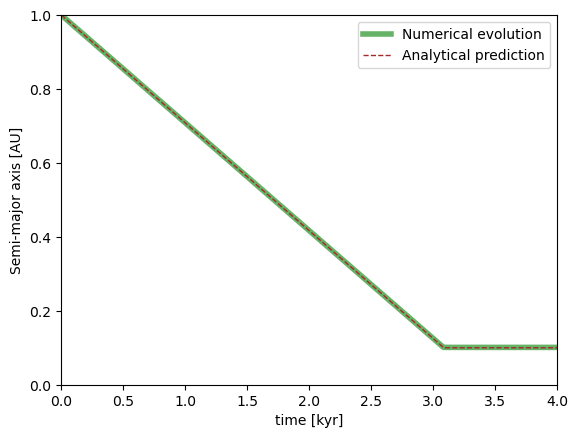

In [9]:
plt.plot(times*0.001, a_integration, label = 'Numerical evolution', c = 'green', linewidth = 4, alpha = 0.6) 
plt.plot(times*0.001, a_analytical, label = 'Analytical prediction', c = 'brown', linestyle = "dashed", linewidth = 1)
plt.xlim(np.min(times)*0.001, np.max(times)*0.001) 
plt.xlabel('time [kyr]')
plt.ylabel('Semi-major axis [AU]')
plt.legend()
plt.ylim(0,1)